# Final Project: Part 3 

The purpose of this notebook is to develop the best predictive model for the `winequality_red` data set where the target variable is the __"quality"__ of the wine.

To do this I will try...  
- Improving the Linear Regression Model 
    - selecting different feature variables  
    - Polynomial transformations / interaction terms / log transformations  
-  Random Forest Regression Model 
- Random Forest Classification Model
- XGboost Classification Model



Standard stuff:

In [227]:
# importing modules

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

In [228]:
# importing data set
wine_df = pd.read_csv('../final_project/winequality-red.csv')

# Quick look at data
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Data details from Part 2

From the preliminary data exploration in Part 2 of this project, the following observations were made:  
- There are no null/na values
- there are 1599 rows and 12 columns 
- The columns that have the highest linear correlation with the target variable are: 

__['volatile acidity', 'citric acid', 'total sulfur dioxide', 'sulphates', 'alcohol']__  
_(determined using SNS heatmap and correlation coeficients)_
- The feature variables 'citric acid' and 'sulphates' are correlated with eachother raising the issue of colinearity. 
- The column 'total sulfur dioxide' has two outliers that may affect the data. 

# "First Pass" Linear Regression Model 
For this first pass model, all non target variables will be used as feature variables in their unchanged form. This will produce the R-squared value that I will try and improve upon.

K-fold cross validation will be used to score the model. 

In [266]:
# Creating target/feature columns

target_col = ['quality']
feature_col = wine_df.columns.drop(target_col)

X = wine_df.loc[:, feature_col]
y = wine_df.loc[:,target_col]

# train-test-split the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [267]:
# Training the model

from sklearn.linear_model import LinearRegression

lr_wine = LinearRegression()
lr_wine.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [268]:
# Scoring the Model with test set

print('Training-set R^2:', lr_wine.score(X_train, y_train))
print('Test-set R^2:', lr_wine.score(X_test, y_test))

Training-set R^2: 0.349905999859534
Test-set R^2: 0.3813656006244428


In [269]:
# Scoring the model with K-fold Cross Vailidation: 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

train_scores = []
test_scores = []
for train_rows, test_rows in kf.split(X, y):
    X_train = X.iloc[train_rows, :]
    X_test = X.iloc[test_rows, :]
    y_train = y.iloc[train_rows]
    y_test = y.iloc[test_rows]

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    train_scores.append(lr.score(X_train, y_train))
    test_scores.append(lr.score(X_test, y_test))
    
print('Training-set R^2:', np.array(train_scores).mean())
print('Test-set R^2:', np.array(test_scores).mean())

Training-set R^2: 0.36150165490041564
Test-set R^2: 0.34966294745026766


__First Pass Summary:__

- The R-Squared Values on the training and test sets produced by the linear model are quite abysmal. (__.36__ and __.35__ respectively). Although this model performs better than a null model, it does so barely.

- Without using Cross Validation, the model's scores varied significantly each time it was run. Using KFold Cross Validation with 5 splits created more confident R-Squared Values.

_Interpretation:_

- Since the R-squared values of the training and test set are so low, the model is __Underfitting__ the data.  

- The model thus has a __Bias__ problem.   

- Because the training and test R-Squared values are relatively close, the model does not have a __variance__ problem.



# Improving the Linear Regession Model 


## Removing Outliers 
Removing outliers in the variable, "total sulfur dioxide"

In [207]:
# dealing with the outliers in 'total sulfur dioxide'


wine_df = wine_df.loc[wine_df.loc[:, 'total sulfur dioxide']<200,:]
wine_df.sort_values('total sulfur dioxide', ascending=False).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,6
1244,5.9,0.290,0.25,13.4,0.067,72.0,160.0,0.99721,3.33,0.54,10.3,6
651,9.8,0.880,0.25,2.5,0.104,35.0,155.0,1.00100,3.41,0.67,11.2,5
109,8.1,0.785,0.52,2.0,0.122,37.0,153.0,0.99690,3.21,0.69,9.3,5
684,9.8,0.980,0.32,2.3,0.078,35.0,152.0,0.99800,3.25,0.48,9.4,5


## Using only Feature variables with high linear correlation to the target variable 
As noted in the observations from the heatmap in part 2, the feature Variables with the highest linear relationship to the target variable are : 

__['volatile acidity', 'citric acid', 'total sulfur dioxide', 'sulphates', 'alcohol']__

However, "citric acid" is colinear with "sulphates". Therefore, this variable will not be used in the feature variable list. Therefore the feature list that will be used is:

__['volatile acidity', 'citric acid', 'total sulfur dioxide', 'sulphates', 'alcohol']__

In [208]:
# Using only selected feature variables:

target_col = ['quality']
feature_col2 = ['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']

X = wine_df.loc[:, feature_col2]
y = wine_df.loc[:,target_col]

# Using K-fold Cross-Val to score the new feature model

kf = KFold(n_splits=5, shuffle=True)

train_scores = []
test_scores = []
for train_rows, test_rows in kf.split(X, y):
    X_train = X.iloc[train_rows, :]
    X_test = X.iloc[test_rows, :]
    y_train = y.iloc[train_rows]
    y_test = y.iloc[test_rows]

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    train_scores.append(lr.score(X_train, y_train))
    test_scores.append(lr.score(X_test, y_test))
    
print('Training-set R^2:', np.array(train_scores).mean())
print('Test-set R^2:', np.array(test_scores).mean())

Training-set R^2: 0.34456669676389184
Test-set R^2: 0.34239173000710776


_Interpretation:_

Removing linearly uncorelated features and "citric acid" caused the R-Squared value to decrease on the test-set and training set compared to using all the features. 

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal number of features : 5


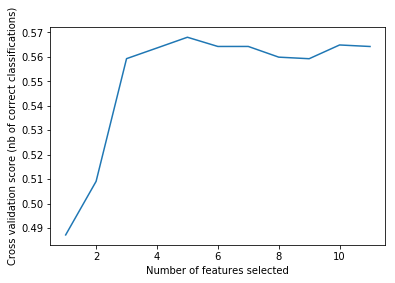

In [209]:
# Using Scikit Learn's Recursive feature elimination with cross-validation to determine
# the optimal number of variables 

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X = wine_df.loc[:, feature_col]
y = wine_df.loc[:,target_col]

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Log Transformation on 'Total Sulfur Dioxide' 

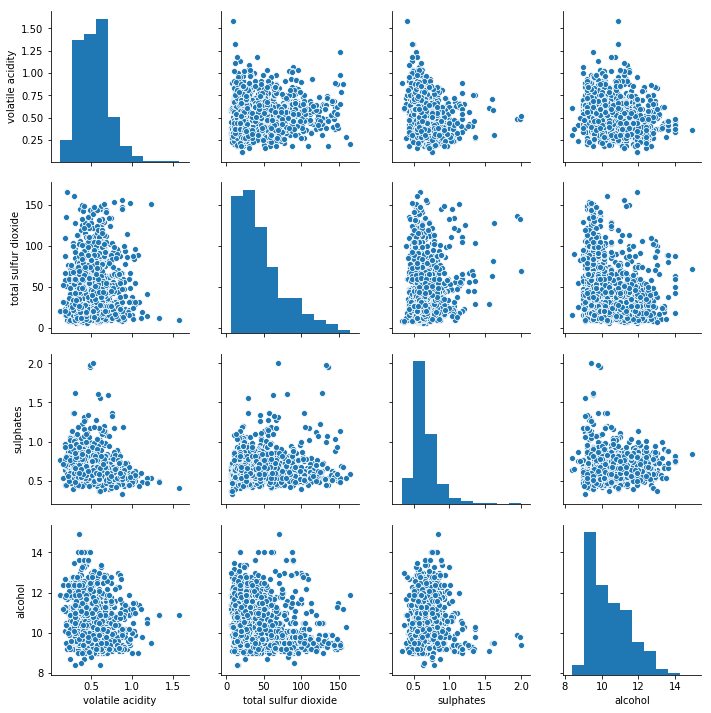

In [210]:
# Looking at the distribution of variables to determine which ones might be 
# Canidates for feature engineering 

X = wine_df.loc[:, feature_col2]
axes = sns.pairplot(X)

__Interpretation:__  
_The variable "Total Sulfur Dioxide" is skewed right. It might yeild better results after a log transformation._

In [211]:
# Creating a column of the log of 'total sulfur dioxide' 

wine_df.loc[:, 'log_tot_sulf_dioxide'] = np.log(wine_df.loc[:, 'total sulfur dioxide'])


# Comparing the RMSE of the unchanged column with the log column 

from sklearn.metrics import mean_squared_error

def train_test_rmse(df, feature_cols):
    X = df.loc[:, feature_cols]
    y = df.loc[:, target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))


print("RMSE with all variables: ", train_test_rmse(wine_df, feature_col))
print("RMSE with only highly linear correlated variables: ", train_test_rmse(wine_df, feature_col2))
print("RMSE with only 'total sulfur dioxide': ", train_test_rmse(wine_df, ['total sulfur dioxide']))
print("RMSE with log transformed 'total sulfur dioxide': ", train_test_rmse(wine_df, ['log_tot_sulf_dioxide']))


RMSE with all variables:  0.6535878849257181
RMSE with only highly linear correlated variables:  0.6628370869065543
RMSE with only 'total sulfur dioxide':  0.7874698970783127
RMSE with log transformed 'total sulfur dioxide':  0.7912846482576608



__Improving the Linear Model Summary:__

- Limiting the variables to the most linearaly correlated features and removing the outliers caused the training R-Squared Value to DECREASE from __.36__ to __.35__  

- Limiting the variables to the most linearaly correlated features and removing the outliers caused the testing R-Squared Value to DECREASE from __.35__ to __.34__  

- Inducing a log transformation on the feature column: 'Total Sulfur Dioxide' caused the RMSE of the model to INCREASE from __.78__ to __.79__ (A lower RMSE is better)

_Interpretation_

- Contrary to my hypothysis, the model performed WORSE with the feature transformations I tried.

- The model still has a large __bias__ problem due to the low R-Squared values

- It likely means that a linear model is not correct for this data set. 

# Random Forest Regression model 

In [212]:
from sklearn.ensemble import RandomForestRegressor

In [213]:
target_col = ['quality']
feature_col = wine_df.columns.drop(['log_tot_sulf_dioxide','quality'])



In [274]:
X = wine_df.loc[:, feature_col]
y = wine_df.loc[:,target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y)

rfr = RandomForestRegressor(n_estimators=200, random_state=123)
rfr.fit(X_train, y_train)

# Evaluating the Model

print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


0.929250802444654
0.46103791654549287


__Random Forest Regression Summary__

- The R-Squared Value on the training set produced by the RFR model is __.92__

- The R-Squared Value on the test set produced by the RFR model is __.46__ 

- Without using Cross Validation, the model's scores were quite stable each time the model was run (fluctuating only about .1)

_Interpretation_ 

- Since the RFR R-squared value on the test set and training set are far apart, the model has a __variance problem__ 

- Even though the model performs well on the training data, it performs poorly on the testing data. Thus the model is __overfitting__ on the training set. 

# Random Forest Classifier

## Preparing the data for a Classification Model

In [280]:
# Getting the data ready by split the 'quality' into "good" (score above 6.4) and "bad" (below 6.5)

bins = (2, 6.5, 8)
group_names = ['bad', 'good']
wine_df.loc[:,'quality_classify'] = pd.cut(wine_df.loc[:,'quality'], bins = bins, labels = group_names)

# Encode "good" and "bad" as 1 and 0 

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

wine_df.loc[:,'quality_binary'] = le.fit_transform(wine_df.loc[:, 'quality_classify'])

In [281]:
wine_df['quality_binary'].value_counts()

0    1382
1     217
Name: quality_binary, dtype: int64

## Applying Random Forest Classification Model

In [282]:
#Train test split the data

X = wine_df.loc[:, feature_col]
y = wine_df.loc[:, 'quality_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [287]:
#Using a standard scaler to scale the data so it is all in the same range

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [292]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, oob_score=True)
rfc.fit(X_train, np.ravel(y_train))
pred_rfc = rfc.predict(X_test)


# Evaluating the Classification model 

print("Mean accuracy:", rfc.score(X_test, y_test))


Mean accuracy: 0.8875


In [220]:
y.value_counts(normalize=True)

0    0.865373
1    0.134627
Name: quality_binary, dtype: float64

In [221]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_rfc))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       352
          1       0.70      0.40      0.51        48

avg / total       0.90      0.91      0.90       400



In [222]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, pred_rfc))

[[344   8]
 [ 29  19]]


In [223]:
rfc.oob_score_ 

0.9072681704260651

__Random Forest Classifier Summary:__  

- From the Confusion Matrix:
    - True Negative = 344
    - True Positive = 19 
    - False Positive = 8
    - False Negative = 29   
    
    
    
- _Mean Accuracy_ (True Positive + True Negative / Total) 
    
    Overall, how often is the classifier correct? 
    The classiier is correct __88%__ of the time.
    
- _Precision: (True Positive / all positive predictions)_    

    When it predicts good wine, how often is it correct?  
    When the model predicts good wine, it is correct __70%__ of the time
    
    When it predicts bad wine, how often is it correct?  
    When the model predicts bad wine, it is correct __90%__ of the time  
    
- _Recall (True Positives / Actual True)_   

    When the wine is good, how often does it predict that the wine is good?
    If the wine is good, the model predicts it __40%__ of the time  
    
    When the wine is bad, how often does it predict that the wine is bad?
    If the wine is bad, the model predicts is __90%__ of the time.
    
- _f1-score (Weighted average of the recall and precision):_       
    total/avg = __.90__

_Interpretation_

- Since the Mean accuracy (.88) is higher than if the model just predicted "bad wine" every time (.86), the model is getting some guidence from the feature variables.  

- Looking at the raw Precision and Recall scores, the model is much better at predicting if the wine is bad than if it is good. If the goal of of the model is not to reccomend bad wines, this is not a bad problem to have. 

- The f1-score is high, meaning that the model overall is doing a good job of predicting True positives and True negatives. With more time, tuning the Probablility Threshold with F_beta scores depending on the importance of Precision vs. Recall would be good next steps. 


# XGBoost Classifier model



In [293]:
import xgboost as xgb

xgb_clas = xgb.XGBClassifier()

In [294]:
xgb_clas.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [295]:
print(xgb_clas.score(X_train, y_train))
print(xgb_clas.score(X_test, y_test))

0.9482902418682235
0.8675


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


__XG Boost Classifier Summary:__   

- The R-Squared Value on the training set produced by the RFR model is __.95__  

- The R-Squared Value on the test set produced by the RFR model is __.86__   

- Without using Cross Validation, the model's scores were quite stable each time the model was run (fluctuating only about .1)  

_Interpretation:_  

The model performs well on both the test set and training set with R_squared values of __.94 and .86__ respectively, making this the most effective model so far..  

Since the scores are relatively high and close together, the model doesn't have much of a bias problem or variance problem.   




# Final Summary

The XGboost model is without a doubt the best model for this data set with an R-Squared value of __.88__ on the test set. 

The biggest lesson I learned from this project is to first try a bunch of different models before trying to improve upon them. I spent alot of time trying to improve a Linear Model which was a waste because it was the wrong model for this data set.   

If I were to do this again I would spend much more time trying to optimize the Random Forest Classifier or XGBoost model than the linear model.  